In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 3
Title         = 'Concrete'
FUR_Weight    = 0.05
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.05, 0.95]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Concrete', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
#Reg_Data.MPL()

In [7]:
Reg_Data.Random_Forest()

0.901232049556716


RandomForestRegressor(random_state=RandomState(MT19937) at 0x19CD9D39A40)

In [8]:
Reg_Data.GP()

-3.5849596232481478


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.5196520700163421


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [279.95048544  74.0163835   53.9467233  182.2559466    6.05424757
 971.69805825 773.63276699  47.29490291]
Std 0:  [104.03532552  87.05435634  64.39813823  21.15992706   5.88045606
  75.47984555  80.2718796   65.02584754]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern_3",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern_3",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

[62.15026667] [6.21502666e+01 1.00000004e-05] [62.15026663]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

INSTANCE:  1
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

[19.0453] [1.90453000e+01 1.00000004e-05] [19.0453]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

INSTANCE:  2
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

[42.7169] [4.27169000e+01 1.00000004e-05] [42.7169]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[32.68472819]
[3.26847282e+01 1.00000004e-05]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


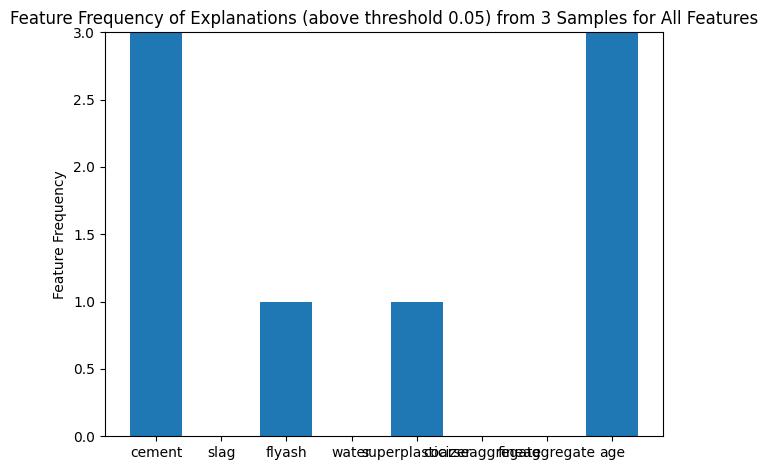

In [18]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           1.7839555555555602  :  2.3341373018634846  :  5.084699999999984
y - exp(x):          1.7839555413281687  :  2.3341373121198674  :  5.084700000046247
BB(x) - exp(x):      1.4258233704822487e-08  :  1.729679412864009e-08  :  3.860613162487425e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  1.0


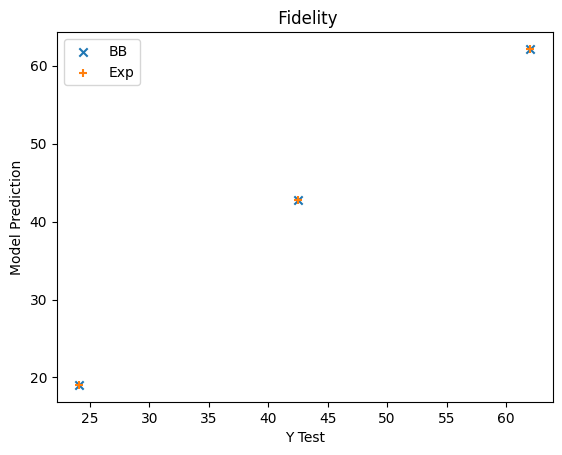

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.4484126984126984
Mean Jaccard Distance:    0.5515873015873016


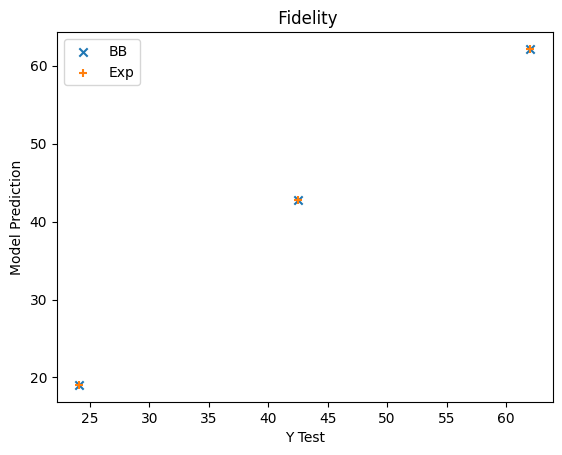

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (3, 8)


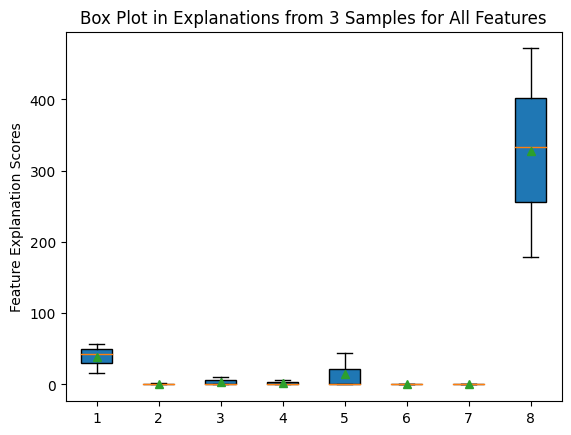

1 -      cement
2 -      slag
3 -      flyash
4 -      water
5 -      superplasticizer
6 -      coarseaggregate
7 -      fineaggregate
8 -      age


In [22]:
Reg_Stats.Box_Plot()


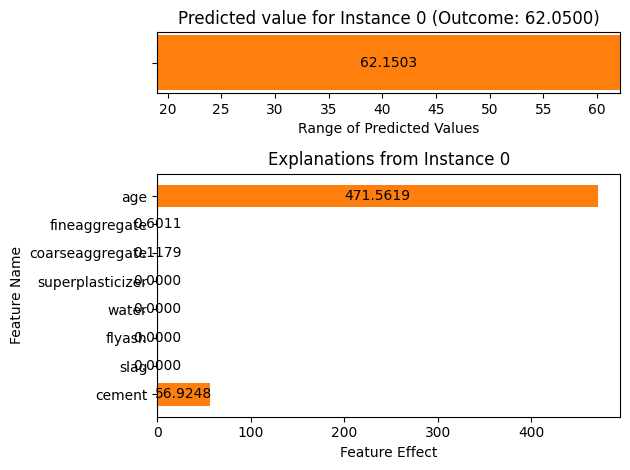

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[1.68673529e+01 5.99666878e-20 1.32603258e+01 4.93659672e+00
 6.46071657e+01 4.02957764e-19 1.86920027e-18 1.93760628e+02]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[1.68880944e+00 4.75425754e-07 1.76910298e+00 1.93498758e+00
 3.10418706e+00 2.69642759e-06 8.70984217e-06 2.12176903e+00]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[1.43002266e+00 4.73695157e-14 3.42808762e-01 3.12099641e+00
 1.01566659e+02 1.32634644e-13 1.20453911e-13 2.63367144e+01]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.67290755e+00 0.00000000e+00 9.92017944e-01 2.40132029e+00
 1.10176070e+00 7.07732779e-10 2.52584252e-09 1.83199351e+00]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[2.94261868e-01 6.92486346e-09 1.94497826e-03 7.35024157e+00
 3.33404805e-01 4.02792231e-08 4.69644719e-09 2.01467284e-02]


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[ 0.12211963  0.02245457 -0.35751244 -0.09822683  0.84459972  0.09209471
  0.04910466  0.30192211]


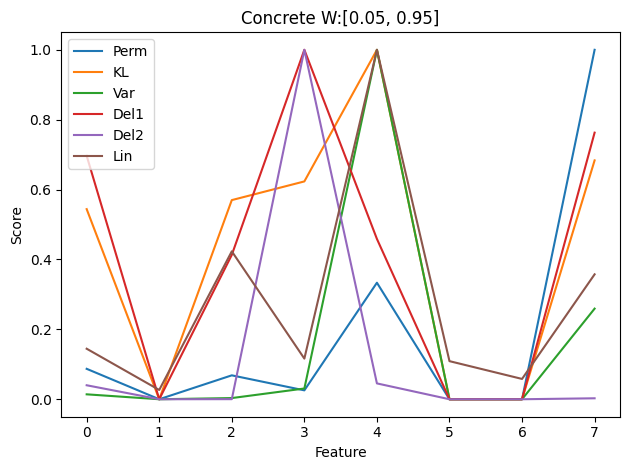

In [30]:
URM_Exp.plot_scores(Title)

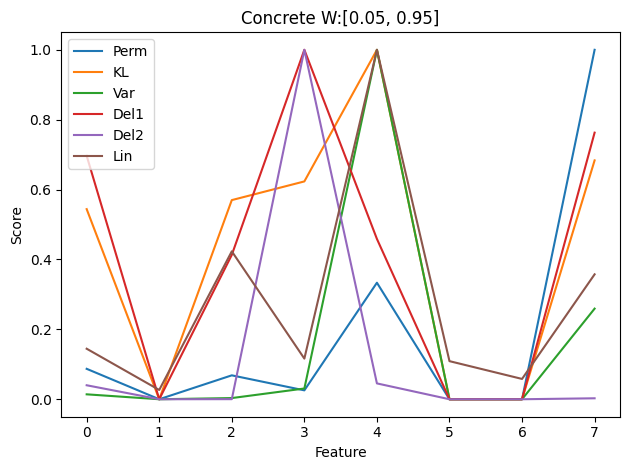

In [31]:
URM_Exp.plot_scores(Title, 'scores_plot')

In [32]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.38245560e-01  7.69832842e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.75587497e-01 -9.18345608e-02  9.56879274e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [33]:
acq_data.Create_BB_plot()

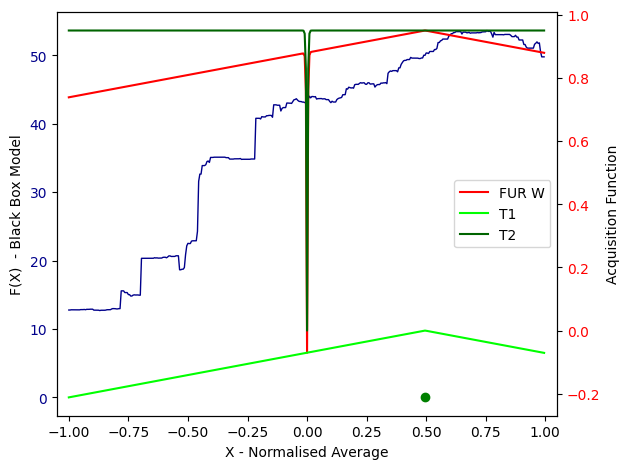

In [34]:
acq_data.plot_point(0)

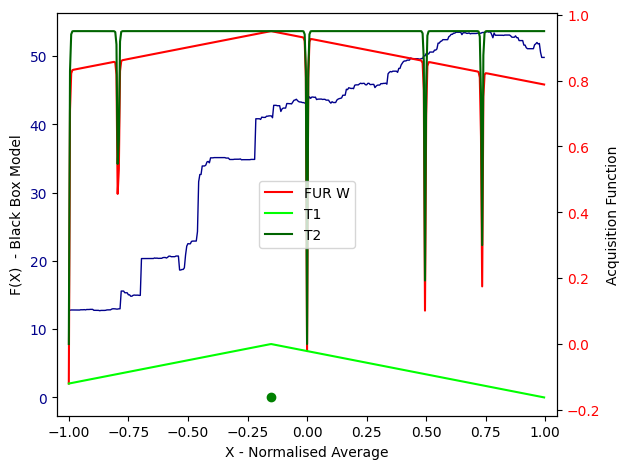

In [35]:
acq_data.plot_point(5)

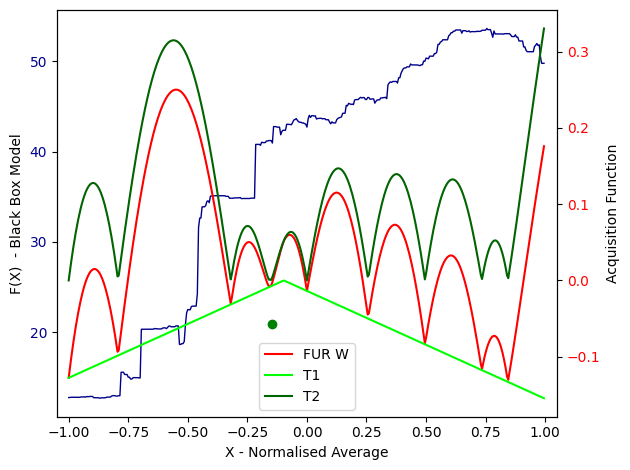

In [36]:
acq_data.plot_point(10)

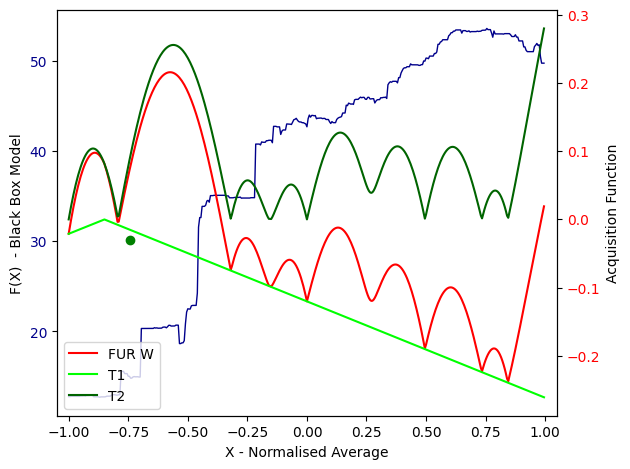

In [37]:
acq_data.plot_point(15)

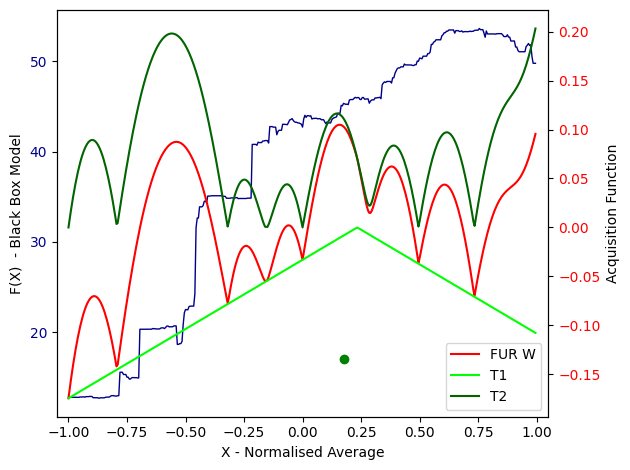

In [38]:
acq_data.plot_point(19)

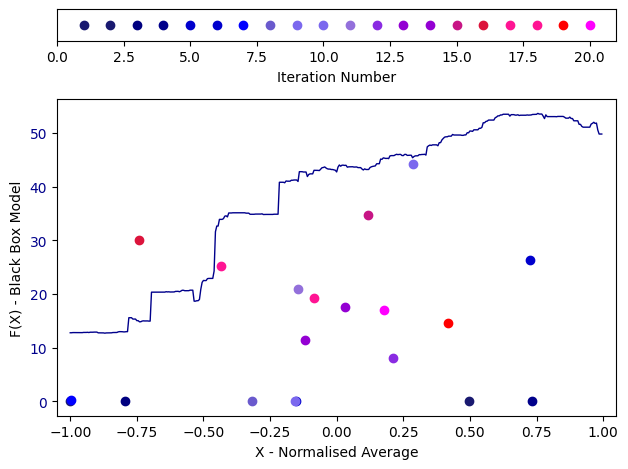

In [39]:
acq_data.plot_all()

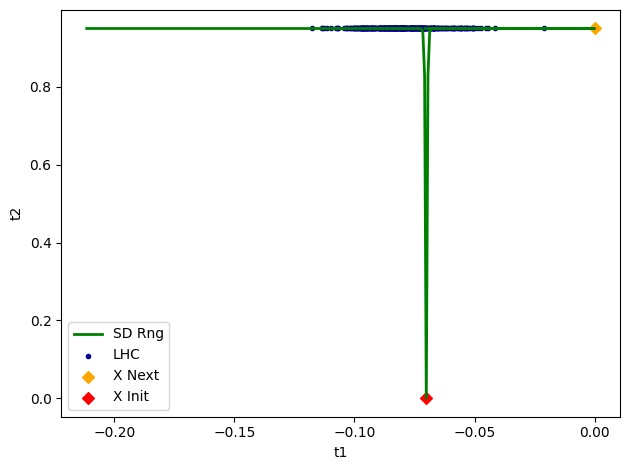

In [40]:
acq_data.plot_t1_t2(0)

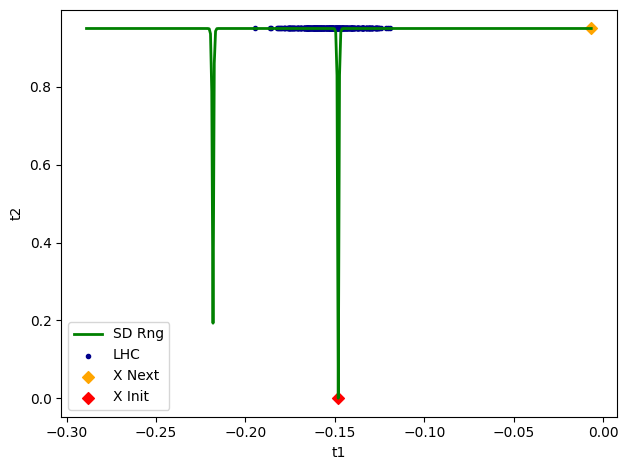

In [41]:
acq_data.plot_t1_t2(1)

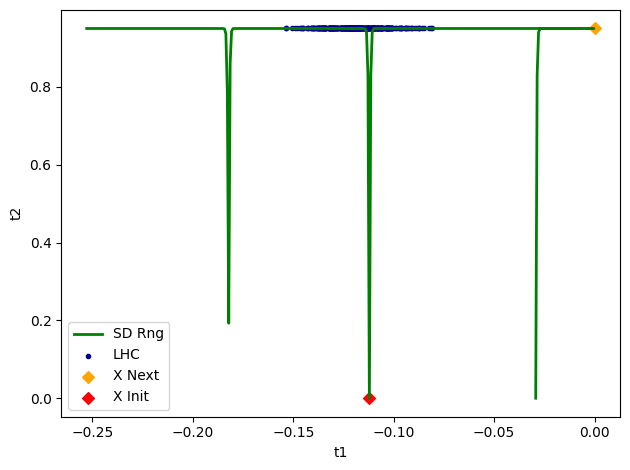

In [42]:
acq_data.plot_t1_t2(2)

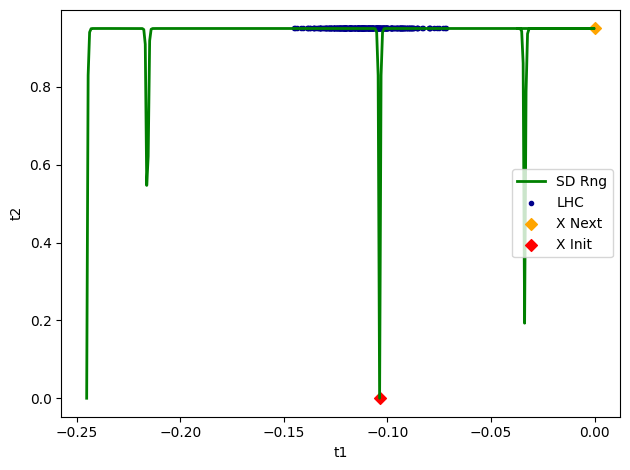

In [43]:
acq_data.plot_t1_t2(3)

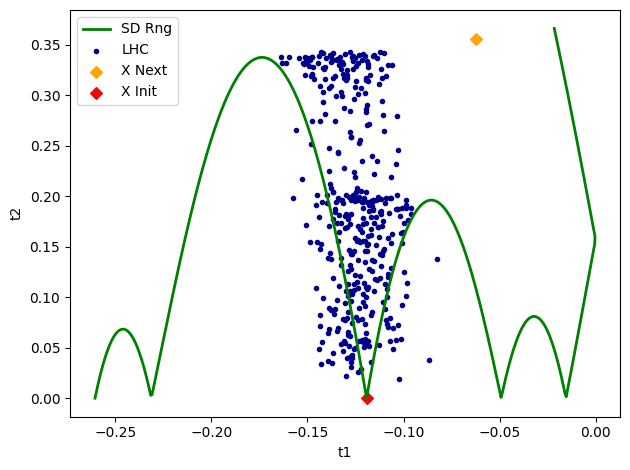

In [44]:
acq_data.plot_t1_t2(4)

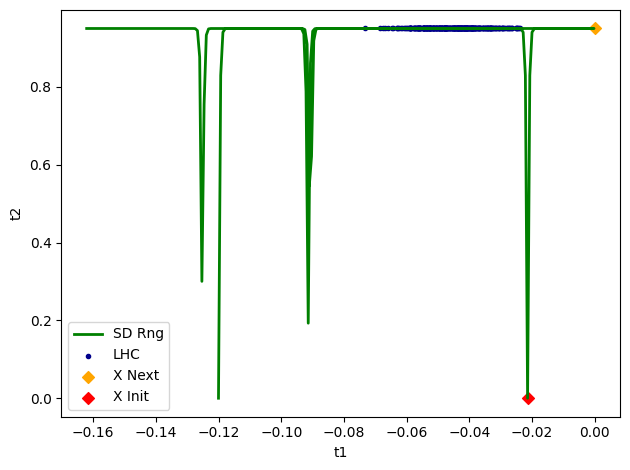

In [45]:
acq_data.plot_t1_t2(5)

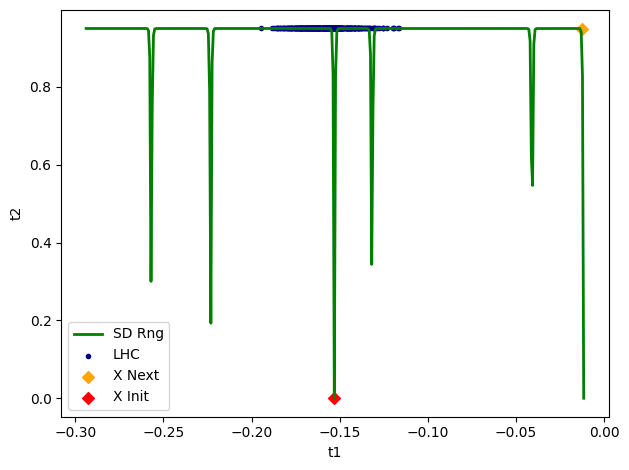

In [46]:
acq_data.plot_t1_t2(6)

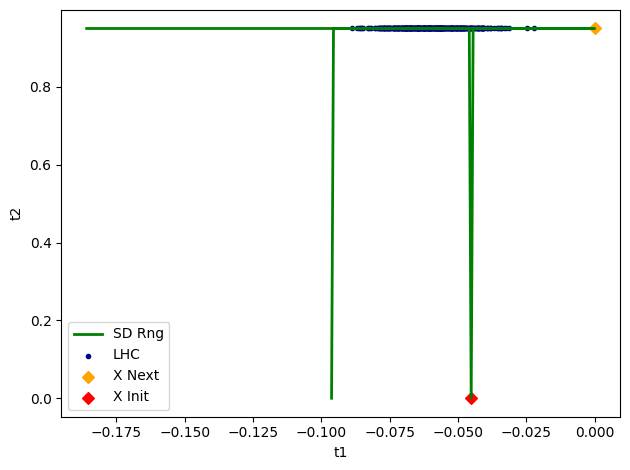

In [47]:
acq_data.plot_t1_t2(7)

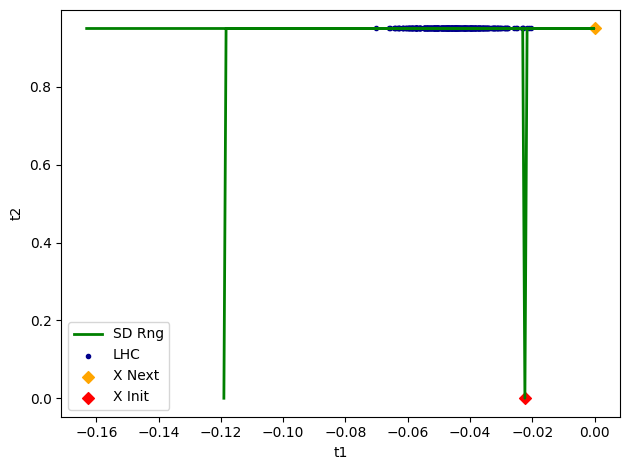

In [48]:
acq_data.plot_t1_t2(8)

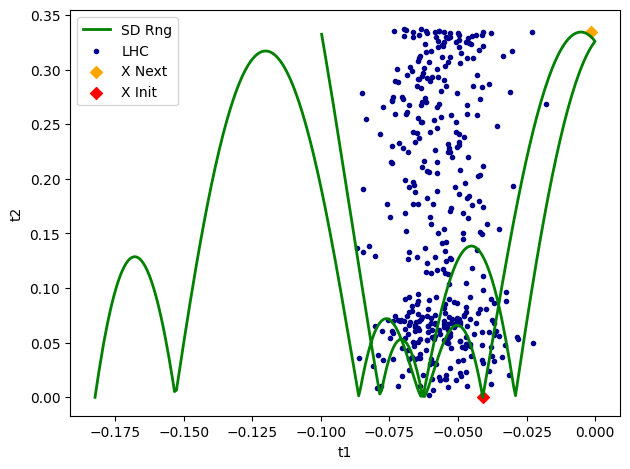

In [49]:
acq_data.plot_t1_t2(9)

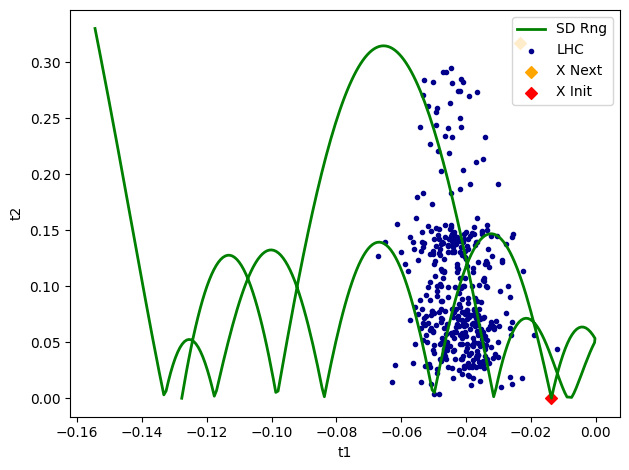

In [50]:
acq_data.plot_t1_t2(10)

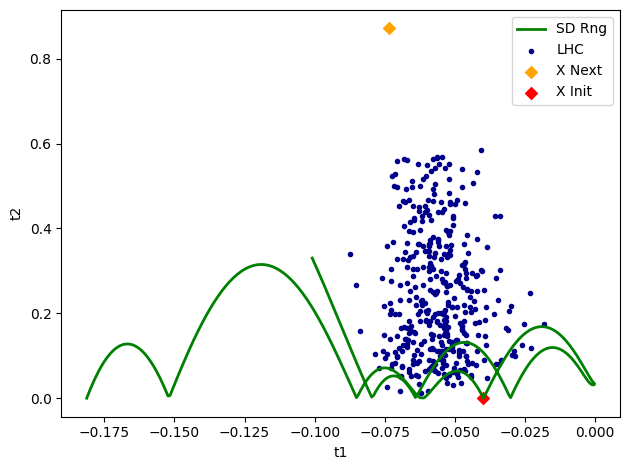

In [51]:
acq_data.plot_t1_t2(11)

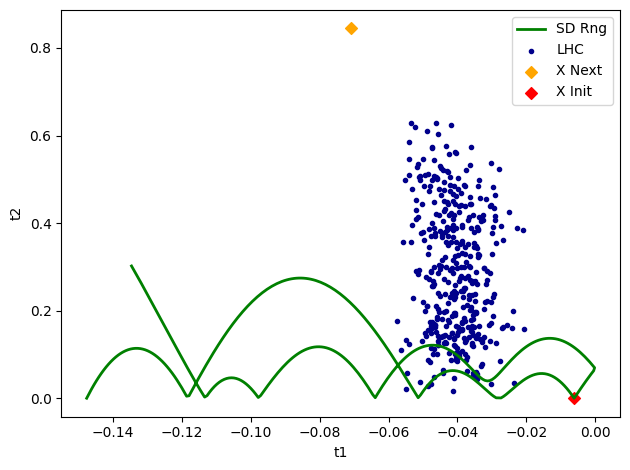

In [52]:
acq_data.plot_t1_t2(12)

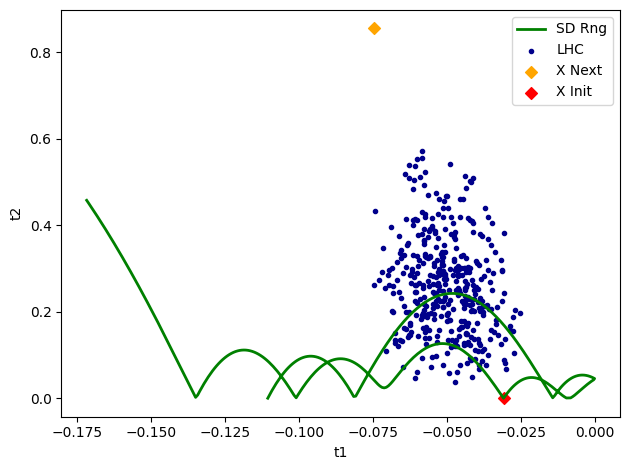

In [53]:
acq_data.plot_t1_t2(13)

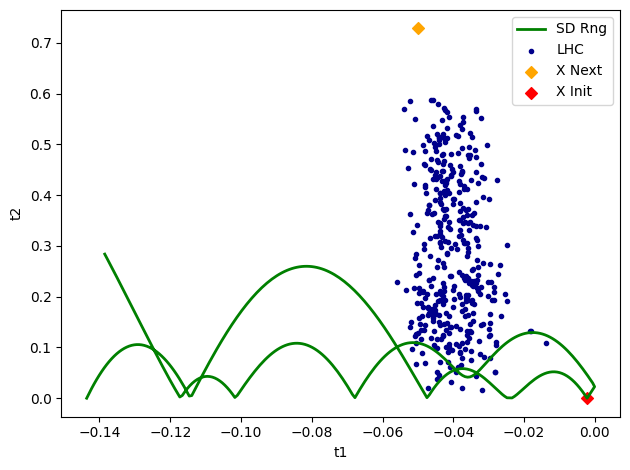

In [54]:
acq_data.plot_t1_t2(14)

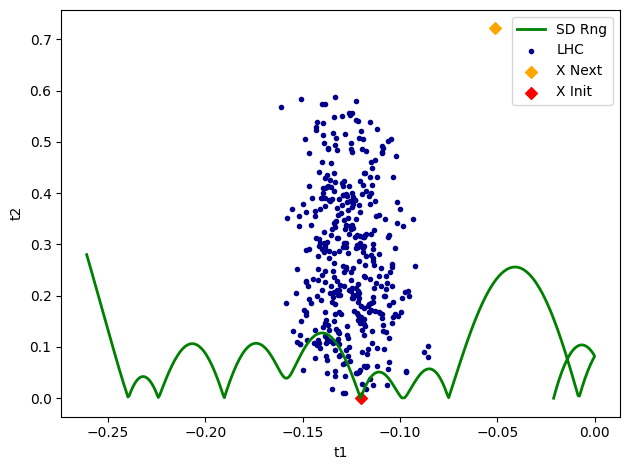

In [55]:
acq_data.plot_t1_t2(15)

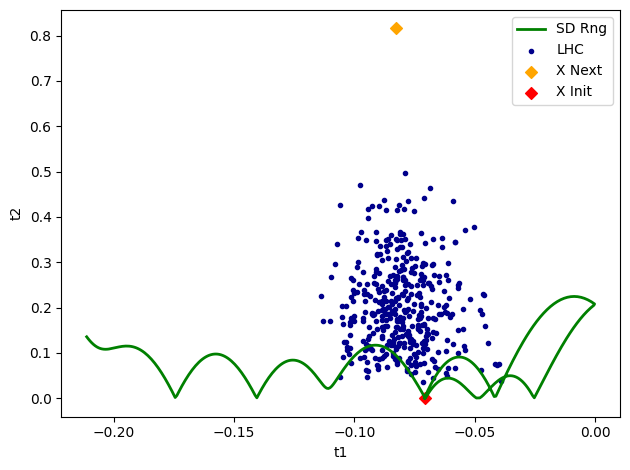

In [56]:
acq_data.plot_t1_t2(16)

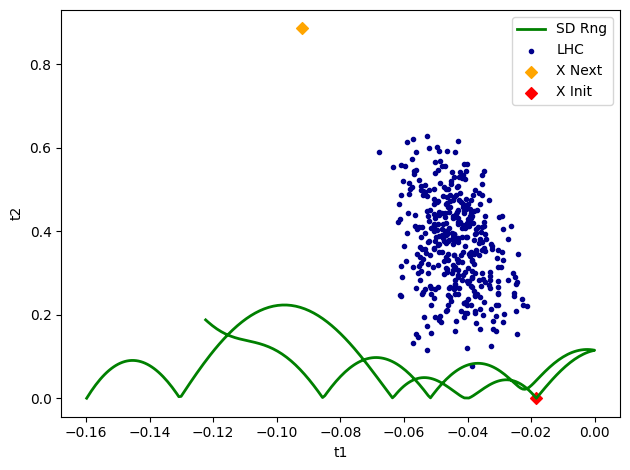

In [57]:
acq_data.plot_t1_t2(17)

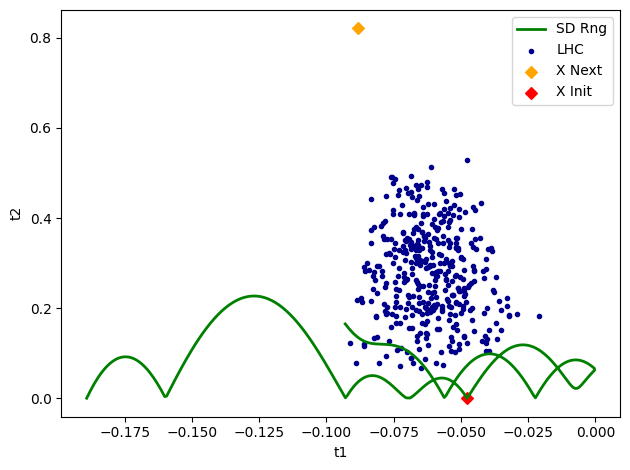

In [58]:
acq_data.plot_t1_t2(18)

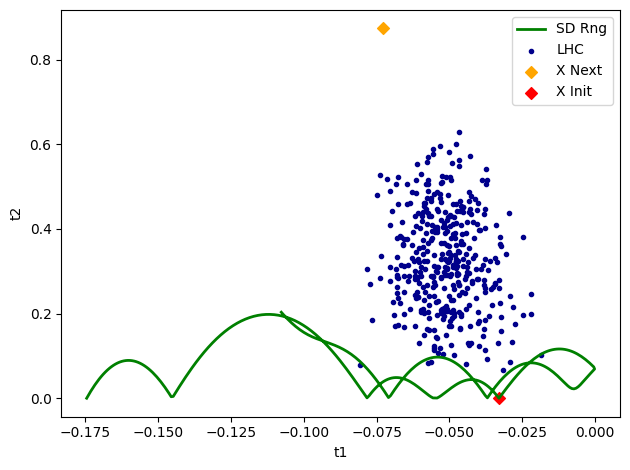

In [59]:
acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           1.7839555555555602  :  2.3341373018634846  :  5.084699999999984
y - exp(x):          1.7839555413281687  :  2.3341373121198674  :  5.084700000046247
BB(x) - exp(x):      1.4258233704822487e-08  :  1.729679412864009e-08  :  3.860613162487425e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  1.0


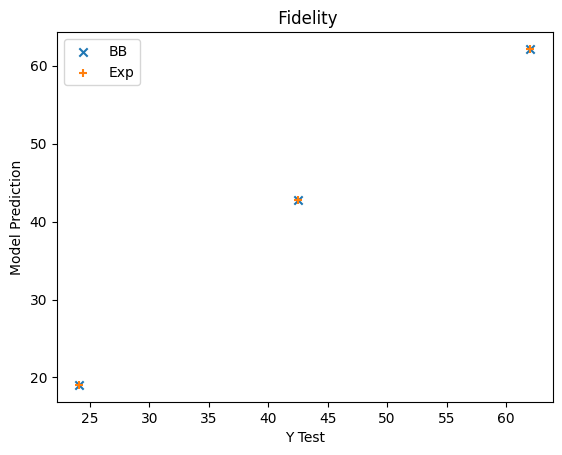

Fidelity:  0.9999999998306908


In [60]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [61]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.4222222222222222
Mean Jaccard Distance:    0.5777777777777778
Jaccard:  0.4222222222222222


N_Points:  25
y_mid, y_pert 1.2599058895642145e-300 [0.00000000e+000 1.79839895e-321 1.20450947e-316 0.00000000e+000
 8.95482224e-312 7.89394771e-312 1.78851764e-321 5.83289762e-302
 0.00000000e+000 3.25701062e-292 1.83792420e-321 2.49208272e-306
 1.25990589e-300 4.59995970e-287 5.52859458e-321 2.50521045e-292
 1.43871315e-311 7.89382467e-312 8.11255790e-321 0.00000000e+000
 1.64181472e-287 4.00421007e-311 0.00000000e+000 0.00000000e+000
 1.39067116e-309]
y_mid, y_pert 3.880973370887848 [1.61044114 3.80935754 7.14499938 6.30903779 0.         6.36365005
 4.18646938 2.16401975 5.09588452 2.2487182  1.8318681  2.31936603
 3.88097337 4.0762793  1.62986116 0.         1.37833753 2.93639282
 4.01344606 2.07973969 4.8378583  4.97523077 2.62222317 1.26385493
 1.64100126]
y_mid, y_pert 1.2599058895642145e-300 [0.00000000e+000 1.79839895e-321 1.20450947e-316 0.00000000e+000
 8.95482224e-312 7.89394771e-312 1.78851764e-321 5.83289762e-302
 0.00000000e+000 3.25701062e-292 1.83792420e-321 2.49208272

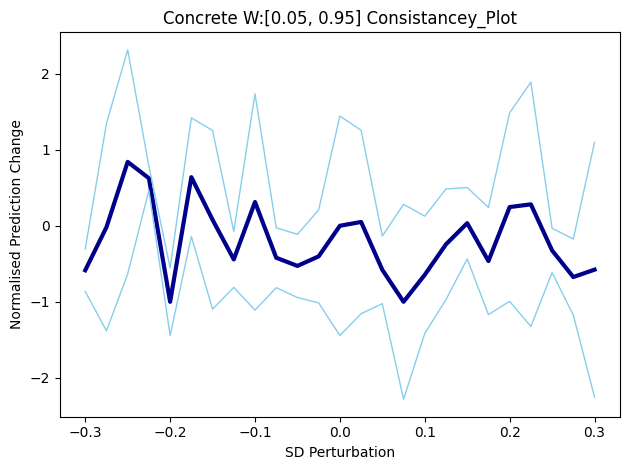

In [62]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [63]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

mean_scores:  [3.87333422e+01 7.62389532e-01 3.73061563e+00 2.00363597e+00
 1.49218617e+01 1.44075892e-01 2.00375784e-01 3.27602583e+02]
mean_scores_d:  [9.48543751e+01 3.32827504e+02 2.87670200e+01 1.30926562e+00
 4.02423653e+00 2.63316152e+00 5.98103111e-02 3.93284029e+02]
Score Diff Mean:  [-0.42010623 -0.99542918 -0.77040695  0.20959583  0.575191   -0.89624517
  0.54024975 -0.09111203]
Score Diff SD:    [0.86084633 1.19066876 0.57859409 1.20719404 0.93427929 1.34831051
 0.76402853 0.5849274 ]
 Model Feature Correlation:  0.710056315595503


Calibration MSE/MAE 0.8080894671760058 0.568367931584445


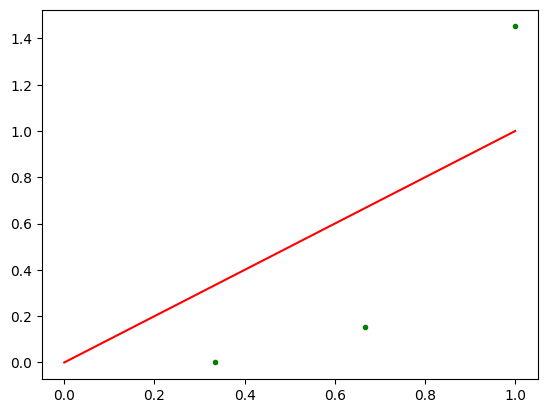

In [64]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [65]:
print(Reg_Stats.calibration_MAE)

0.568367931584445


In [66]:
Reg_Stats.Regression_Calibration_2(plot=True, title=Title)

root_mean_squared_calibration_error:  0.5701024776448835
mean_absolute_calibration_error:  0.49


In [67]:
Reg_Stats.add_bb_del_1(Reg_Data.Random_Forest())
Reg_Stats.delete_one()

0.8991529078704927
[[45.32966667  1.41041667  1.11039167  2.55610833  7.67986667  5.44424167
   0.89206333 34.42147833]
 [ 5.9292      0.9789      1.082       0.16873333  1.6325      0.79826667
   6.95833333  4.6074    ]
 [17.8474      0.9651      0.7322      2.6009      5.3373      0.3709
   3.9057     27.5747    ]]
mean_variance [3.12307178e+01 2.14011570e-02 4.17293366e+00 1.39175456e+01
 4.63402739e+00 1.54613063e+01 1.06502779e+01 2.11332534e+01]
Mean scores: [3.87333422e+01 7.62389532e-01 3.73061563e+00 2.00363597e+00
 1.49218617e+01 1.44075892e-01 2.00375784e-01 3.27602583e+02]
sort_order [5 6 1 3 2 4 0 7]
norm sorted_scores [2.96988010e-03 4.13040685e-03 1.57153668e-02 4.13015565e-02
 7.69003123e-02 3.07588864e-01 7.98422140e-01 6.75297147e+00]
norm sorted_variance [1.22197849e+00 8.41740681e-01 1.69143234e-03 1.09996794e+00
 3.29806231e-01 3.66248600e-01 2.46830795e+00 1.67025868e+00]
Mean BB Variance:  [23.03542222  1.11813889  0.97486389  1.77524722  4.88322222  2.20446944
 

In [68]:
Reg_Stats.Results_Summary(Title)

Results_Summary: Concrete W:[0.05, 0.95]
Timestamp:  2023-05-14 00:07:08.572699
 Model Feature Correlation:  0.710056315595503
R Score:   1.0
Fidelity:  1.0
Consistancey Std/Y Pert:  0.3 : -0.5811047789758119
Delete 1 error:          1.2741841826550946
Delete 1 Correlation:    0.41249732614001483
Delete 1 BB Correlation: 0.8266203711577575
Mean Jaccard Similarity:  0.4222222222222222
Mean Jaccard Distance:    0.5777777777777778
Calibration MSE/MAE:  0.8080894671760058 : 0.568367931584445
 Model Feature Correlation:  0.710056315595503
